In [1]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from cubist import Cubist
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [3]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


# Step 0: Setting up decision paramenters (Data Tree)

In [4]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum', 'log']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [0, 5, 10, 15,20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,  100]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['Sand', 'Silt', 'Clay', 'TOC', 'CaCO3']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']

# 7. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'cubist', 'svr', 'ridge', 'gbrt']

# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']

# Step 1a: Obtaining Spectra (Noise and Outliers removal)

In [5]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [6]:
legacy_spec = pd.read_csv('spectra.csv')
legacy_tar = pd.read_csv('targets.csv')

#
# legacy_spec.head(2)
legacy_spec.rename(columns= {'sample':'id'}, inplace=True)
legacy_tar.rename(columns = {'SOIL': 'id', 'CLAI':'Clay', 'SILT': 'Silt', 'SAND': 'Sand', 'OC': 'TOC', 'CACO3':'CaCO3'}, inplace = True)

In [7]:
legacy_spec = legacy_spec.set_index('id', drop=True)
legacy_tar = legacy_tar.set_index('id', drop=True)

In [8]:
legacy_tar.iloc[:,1]

id
E1     13.9719
E2      8.8638
E3     25.5598
E4     16.5819
E5     33.8471
        ...   
S15    20.8965
S16    18.1648
S17    19.4014
S18    30.0658
S19    22.1944
Name: Clay, Length: 91, dtype: float64

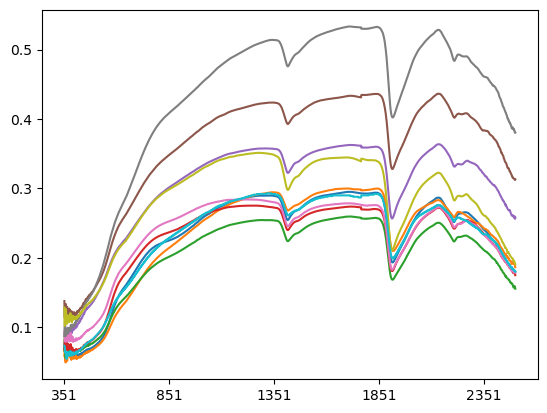

In [9]:
for i in range (0,10,1):
    legacy_spec.iloc[i,1:].plot()

In [10]:
legacy_spectra = legacy_spec.iloc[:, 101::].copy()
legacy_spectra

,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,...,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1,0.066222,0.066322,0.066222,0.066122,0.066522,0.066922,0.067422,0.068022,0.067578,0.066922,0.067422,0.067322,0.067322,0.067922,0.067622,0.067822,0.068622,0.068122,0.068122,0.068622,0.069404,0.069322,0.069022,0.069022,0.069322,0.069522,0.069622,0.069622,0.069822,0.070122,0.070322,0.070422,0.070722,0.071222,0.071222,0.071222,0.071422,0.071522,0.071622,0.071922,0.072322,0.072622,0.072822,0.073022,0.073122,0.073322,0.073622,0.073722,0.073991,0.074322,...,0.198465,0.197661,0.196834,0.196530,0.196182,0.195595,0.195123,0.194908,0.194592,0.193903,0.193152,0.192428,0.191843,0.191818,0.191789,0.191838,0.191824,0.191501,0.191119,0.190578,0.190130,0.190035,0.189680,0.188474,0.187274,0.186151,0.185481,0.186149,0.186492,0.185993,0.185726,0.185862,0.186042,0.186245,0.186060,0.185331,0.184433,0.183245,0.182729,0.183108,0.182604,0.180906,0.179802,0.179577,0.179448,0.179298,0.179278,0.179380,0.179692,0.180275
A2,0.062870,0.063270,0.063270,0.062870,0.062970,0.063370,0.064170,0.064770,0.064170,0.063370,0.064370,0.064270,0.064170,0.065070,0.064770,0.064870,0.065385,0.065170,0.065023,0.065170,0.065870,0.065770,0.065670,0.066100,0.066270,0.066370,0.066470,0.066970,0.067070,0.067070,0.067170,0.067170,0.067470,0.068070,0.068082,0.068035,0.068070,0.068331,0.068470,0.068570,0.069070,0.069470,0.069670,0.069770,0.069970,0.070170,0.070370,0.070470,0.070870,0.071232,...,0.205569,0.205255,0.204990,0.205285,0.205434,0.204261,0.203190,0.202188,0.201262,0.201817,0.202313,0.202066,0.201720,0.200781,0.199900,0.199475,0.199150,0.199420,0.199386,0.198038,0.196890,0.196577,0.196325,0.196292,0.196133,0.195575,0.195193,0.195342,0.195309,0.194835,0.193872,0.191836,0.191037,0.192613,0.193641,0.193872,0.193701,0.192865,0.192286,0.192020,0.191992,0.192217,0.191915,0.191090,0.190970,0.191688,0.190903,0.188633,0.187193,0.186471
A3,0.072381,0.072581,0.072581,0.072426,0.072407,0.072981,0.074081,0.074281,0.073681,0.072981,0.073881,0.073581,0.073381,0.074081,0.073681,0.073781,0.074281,0.074181,0.074381,0.074881,0.075281,0.074881,0.074781,0.075458,0.075681,0.075781,0.075981,0.076181,0.076181,0.076181,0.076326,0.076481,0.076781,0.077281,0.076981,0.076924,0.077081,0.077481,0.077681,0.077781,0.078481,0.078581,0.078681,0.078981,0.079181,0.079354,0.079581,0.079781,0.080081,0.080381,...,0.174165,0.173592,0.173154,0.173660,0.174029,0.173120,0.172276,0.171809,0.171302,0.170980,0.170673,0.170586,0.170480,0.170197,0.169895,0.169567,0.169197,0.168584,0.168091,0.168160,0.168105,0.167602,0.166950,0.165840,0.164941,0.164731,0.164606,0.164703,0.164497,0.163539,0.162940,0.163157,0.163235,0.162976,0.162727,0.162552,0.161770,0.160198,0.159199,0.158877,0.158239,0.157131,0.157237,0.158758,0.159393,0.159307,0.159010,0.158455,0.157325,0.155563
A4,0.075568,0.075968,0.076168,0.075868,0.076168,0.076668,0.077468,0.077968,0.077385,0.076668,0.077468,0.077568,0.077668,0.078368,0.077968,0.078068,0.078868,0.078668,0.078521,0.078668,0.079368,0.079318,0.079268,0.079868,0.080027,0.080168,0.080468,0.080668,0.080768,0.080851,0.081068,0.081268,0.081468,0.082068,0.082068,0.082168,0.082468,0.082668,0.082768,0.082868,0.083668,0.083968,0.084168,0.084491,0.084768,0.084973,0.085250,0.085568,0.085968,0.086368,...,0.194306,0.194194,0.194145,0.194560,0.194873,0.194528,0.194057,0.192961,0.191965,0.191607,0.191148,0.190214,0.189585,0.190566,0.191265,0.190437,0.189540,0.188498,0.187500,0.186704,0.186006,0.185752,0.185634,0.185984,0.186019,0.185100,0.184457,0.184652,0.184615,0.

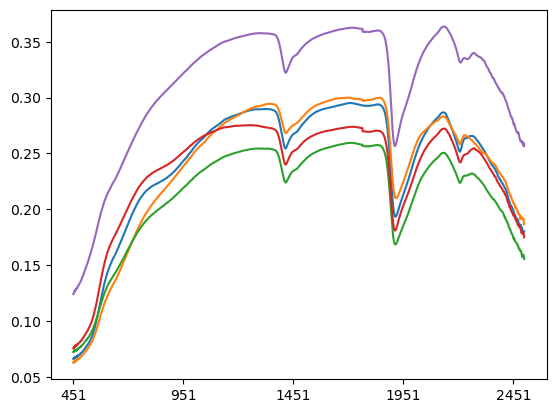

In [11]:
for i in range (0,5,1):
    legacy_spectra.iloc[i,:].plot()

In [12]:
legacy_tar = legacy_tar[['Clay', 'Silt', 'Sand', 'TOC', 'CaCO3']]
legacy_tar.head(2)

,Clay,Silt,Sand,TOC,CaCO3
id,,,,,
E1,13.9719,0.0000,86.0281,0.59,1.83
E2,8.8638,2.5181,88.6180,0.17,0.00


In [13]:
print(legacy_spectra.shape)
print(legacy_tar.shape)

# Note that some id are missing in the data so we will do preprocessing to fix it ---------

(89, 2050)
(91, 5)


In [14]:
# Missing ID's are taken care by setting the index to ID and obtaining inner join.


legacy_fr = pd.merge(legacy_tar, legacy_spectra, on = 'id', how = 'inner')

legacy_fr.reset_index(inplace = True)
legacy_fr .head(35)

print('Missing:', legacy_fr.isnull().sum().sum())   # alternate to previous (inferred from next command)
print(legacy_fr.isnull().sum()) # isnull applies to df but isnan applies only to ndarray

legacy_fr.dropna(axis=0, inplace = True)

Missing: 3
id      0
Clay    1
Silt    1
Sand    1
TOC     0
       ..
2496    0
2497    0
2498    0
2499    0
2500    0
Length: 2056, dtype: int64


In [15]:
spectra = legacy_fr.iloc[:, 6::]
spectra

,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,...,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.060500,0.061100,0.061800,0.062400,0.062400,0.062500,0.062800,0.063200,0.063100,0.063000,0.063700,0.063700,0.063800,0.064300,0.064300,0.064500,0.064800,0.065300,0.065300,0.065200,0.065500,0.065800,0.065900,0.065700,0.066300,0.066500,0.066400,0.066900,0.067300,0.067600,0.067600,0.068000,0.068400,0.068700,0.068600,0.068800,0.069300,0.069600,0.069900,0.070200,0.070700,0.071200,0.071500,0.071600,0.072100,0.072700,0.073300,0.073400,0.073700,0.074200,...,0.350000,0.349000,0.348000,0.347000,0.346000,0.345000,0.345000,0.344000,0.343000,0.343000,0.342000,0.342000,0.341000,0.340000,0.339000,0.339000,0.338000,0.338000,0.337000,0.337000,0.336000,0.335000,0.334000,0.333000,0.333000,0.332000,0.332000,0.331000,0.330000,0.329000,0.328000,0.328000,0.327000,0.327000,0.327000,0.326000,0.326000,0.325000,0.325000,0.324000,0.323000,0.323000,0.322000,0.321000,0.321000,0.321000,0.320000,0.319000,0.319000,0.320000
1,0.064000,0.064200,0.064400,0.064900,0.065100,0.065400,0.065800,0.065500,0.065600,0.065900,0.066600,0.066600,0.066700,0.067400,0.067500,0.067500,0.067500,0.067900,0.068200,0.068400,0.068600,0.068700,0.068800,0.069200,0.069400,0.069600,0.069800,0.070100,0.070400,0.070600,0.070700,0.070800,0.071100,0.071600,0.072000,0.072400,0.072800,0.073100,0.073400,0.073600,0.074200,0.074800,0.075200,0.075500,0.075800,0.076300,0.076900,0.077400,0.077900,0.078500,...,0.380000,0.380000,0.379000,0.378000,0.378000,0.377000,0.376000,0.375000,0.374000,0.374000,0.373000,0.372000,0.372000,0.371000,0.370000,0.370000,0.370000,0.369000,0.368000,0.367000,0.366000,0.365000,0.365000,0.364000,0.364000,0.363000,0.362000,0.362000,0.361000,0.360000,0.359000,0.358000,0.358000,0.357000,0.357000,0.356000,0.356000,0.356000,0.356000,0.355000,0.354000,0.354000,0.353000,0.352000,0.351000,0.350000,0.350000,0.351000,0.351000,0.350000
2,0.048300,0.048700,0.049100,0.049500,0.049600,0.049600,0.049700,0.050100,0.050200,0.050200,0.050700,0.050500,0.050500,0.051100,0.051000,0.051100,0.051400,0.051700,0.051700,0.051700,0.052000,0.052100,0.052100,0.052000,0.052400,0.052600,0.052400,0.053000,0.053300,0.053400,0.053400,0.053600,0.053900,0.054100,0.054000,0.054100,0.054400,0.054800,0.055000,0.055100,0.055500,0.055900,0.056100,0.056200,0.056400,0.056800,0.057400,0.057400,0.057700,0.058000,...,0.250000,0.250000,0.249000,0.248000,0.248000,0.247000,0.247000,0.246000,0.245000,0.245000,0.244000,0.243000,0.243000,0.242000,0.242000,0.241000,0.240000,0.239000,0.239000,0.238000,0.237000,0.236000,0.235000,0.234000,0.234000,0.234000,0.234000,0.233000,0.232000,0.231000,0.231000,0.230000,0.230000,0.229000,0.228000,0.228000,0.228000,0.227000,0.226000,0.226000,0.226000,0.225000,0.225000,0.224000,0.224000,0.223000,0.222000,0.221000,0.221000,0.221000
3,0.055200,0.055300,0.055600,0.056400,0.056200,0.056200,0.056400,0.056800,0.056900,0.056900,0.057400,0.057200,0.057300,0.058000,0.058000,0.058000,0.058200,0.058700,0.058800,0.058600,0.059000,0.059300,0.059400,0.059300,0.059800,0.060000,0.059800,0.060400,0.060800,0.061100,0.060800,0.061100,0.061500,0.062000,0.061900,0.062000,0.062300,0.062600,0.062800,0.063100,0.063500,0.063900,0.064200,0.064400,0.064700,0.065200,0.065700,0.065800,0.066100,0.066400,...,0.282000,0.282000,0.281000,0.281000,0.280000,0.279000,0.279000,0.278000,0.278000,0.277000,0.277000,0.276000,0.275000,0.275000,0.274000,0.273000,0.272000,0.272000,0.271000,0.271000,0.270000,0.269000,0.269000,0.268000,0.268000,0.267000,0.267000,0.266000,0.265000,0.265000,0.264000,0.264000,0.263000,0.263000,0.263000,0.262000,0.261000,0.261000,0.260000,0.260000,0.260000,0.

# Step 1b: Obtaining Targets (Outliers removal and Normalization)

In [16]:
df = legacy_fr
# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green', 'blue']

def isolate_targets(df, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(df[target_names[i]])
    return(T)
    
T = isolate_targets(df,target_names) 

def normalize_targets(T):          
    NT =[]
    for i in range(0, len(T)):
        NT.append(min_max_normal(T[i].copy()))
    return(NT)

NT = normalize_targets(T)

# Step 1c: Spectra Preprocessing (Smooth, FOD/Contin, and Resample)

## Savgol smoothing (order 1 and order 2)

In [17]:
# -------------- Smoothed Spectra spec1 (savgol order 1) and spec2 (savgol order 2)  -----------

spec1 = {}
for i in window_lengths:
    spec1[i] = filt_sg(spectra, i, 'sg1')                   

spec2 = {}
for i in window_lengths:
    spec2[i] = filt_sg(spectra, i, 'sg2')

smth_spec = sgsmooth (spectra, 3)    

## First Order Derivative

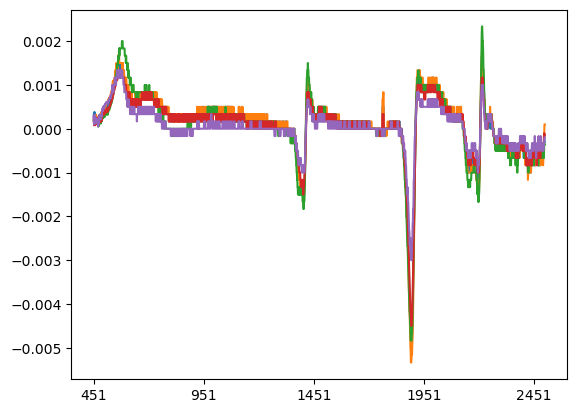

In [18]:
fod_spec = fod(smth_spec)

for i in range (0,5,1):
    fod_spec.iloc[i,:].plot()


## Continuum Removal

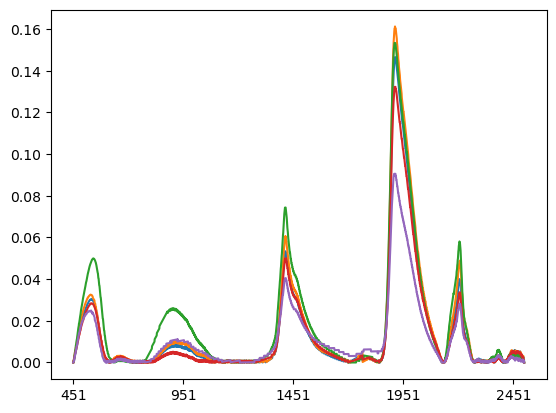

In [19]:
cr_spec = continuum_removed(spec2[51])

for i in range (0,5,1):
    cr_spec.iloc[i,:].plot()
    

## 1/logR Transformation

In [20]:
log_spec = ((1/spec2[51]).apply(np.log)).copy()
log_spec.head(5)

,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,...,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2.805112,2.795243,2.783852,2.774190,2.774190,2.772589,2.767800,2.761451,2.763035,2.764621,2.753571,2.753571,2.752002,2.744196,2.744196,2.741090,2.736450,2.728763,2.728763,2.730296,2.725705,2.721135,2.719617,2.722656,2.713565,2.710553,2.712058,2.704556,2.698595,2.694147,2.694147,2.688248,2.682382,2.678006,2.679463,2.676552,2.669310,2.664991,2.660690,2.656407,2.649310,2.642262,2.638058,2.636660,2.629701,2.621414,2.613195,2.611831,2.607752,2.600991,...,1.049822,1.052683,1.055553,1.058430,1.061317,1.064211,1.064211,1.067114,1.070025,1.070025,1.072945,1.072945,1.075873,1.078810,1.081755,1.081755,1.084709,1.084709,1.087672,1.087672,1.090644,1.093625,1.096614,1.099613,1.099613,1.102620,1.102620,1.105637,1.108663,1.111698,1.114742,1.114742,1.117795,1.117795,1.117795,1.120858,1.120858,1.123930,1.123930,1.127012,1.130103,1.130103,1.133204,1.136314,1.136314,1.136314,1.139434,1.142564,1.142564,1.139434
1,2.748872,2.745752,2.742642,2.734908,2.731831,2.727233,2.721135,2.725705,2.724180,2.719617,2.709051,2.709051,2.707550,2.697110,2.695628,2.695628,2.695628,2.689719,2.685311,2.682382,2.679463,2.678006,2.676552,2.670754,2.667868,2.664991,2.662121,2.657832,2.653562,2.650725,2.649310,2.647896,2.643668,2.636660,2.631089,2.625549,2.620039,2.615927,2.611831,2.609110,2.600991,2.592937,2.587604,2.583623,2.579657,2.573082,2.565249,2.558768,2.552329,2.544657,...,0.967584,0.967584,0.970219,0.972861,0.972861,0.975510,0.978166,0.980829,0.983499,0.983499,0.986177,0.988861,0.988861,0.991553,0.994252,0.994252,0.994252,0.996959,0.999672,1.002393,1.005122,1.007858,1.007858,1.010601,1.010601,1.013352,1.016111,1.016111,1.018877,1.021651,1.024433,1.027222,1.027222,1.030019,1.030019,1.032825,1.032825,1.032825,1.032825,1.035637,1.038458,1.038458,1.041287,1.044124,1.046969,1.049822,1.049822,1.046969,1.046969,1.049822
2,3.030324,3.022076,3.013896,3.005783,3.003764,3.003764,3.001750,2.993734,2.991740,2.991740,2.981829,2.985782,2.985782,2.973971,2.975930,2.973971,2.968117,2.962297,2.962297,2.962297,2.956512,2.954590,2.954590,2.956512,2.948849,2.945039,2.948849,2.937463,2.931819,2.929945,2.929945,2.926206,2.920625,2.916921,2.918771,2.916921,2.911391,2.904065,2.900422,2.898606,2.891372,2.884191,2.880619,2.878839,2.875286,2.868219,2.857711,2.857711,2.852498,2.847312,...,1.386294,1.386294,1.390302,1.394327,1.394327,1.398367,1.398367,1.402424,1.406497,1.406497,1.410587,1.414694,1.414694,1.418818,1.418818,1.422958,1.427116,1.431292,1.431292,1.435485,1.439695,1.443923,1.448170,1.452434,1.452434,1.452434,1.452434,1.456717,1.461018,1.465338,1.465338,1.469676,1.469676,1.474033,1.478410,1.478410,1.478410,1.482805,1.487220,1.487220,1.487220,1.491655,1.491655,1.496109,1.496109,1.500584,1.505078,1.509593,1.509593,1.509593
3,2.896792,2.894982,2.889572,2.875286,2.878839,2.878839,2.875286,2.868219,2.866460,2.866460,2.857711,2.861201,2.859455,2.847312,2.847312,2.847312,2.843870,2.835316,2.833613,2.837021,2.830218,2.825146,2.823461,2.825146,2.816750,2.813411,2.816750,2.806766,2.800165,2.795243,2.800165,2.795243,2.788718,2.780621,2.782235,2.780621,2.775794,2.770990,2.767800,2.763035,2.756715,2.750436,2.745752,2.742642,2.737994,2.730296,2.722656,2.721135,2.716587,2.712058,...,1.265848,1.265848,1.269401,1.269401,1.272966,1.276543,1.276543,1.280134,1.280134,1.283738,1.283738,1.287354,1.290984,1.290984,1.294627,1.298283,1.301953,1.301953,1.305636,1.305636,1.309333,1.313044,1.313044,1.316768,1.316768,1.320507,1.320507,1.324259,1.328025,1.328025,1.331806,1.331806,1.335601,1.335601,1.335601,1.339411,1.343235,1.343235,1.347074,1.347074,1.347074,1.

## Resampling (n_bands)

### 1. Sampled Original (sampled_spec: sampled clipped_spectra)

In [21]:
sampled_spec = {}
for n in nbands_sampling:
    sampled_spec[n] = resample_spectra (spec2[51], n)

In [22]:
# for i in range (0,5,1):
#     sampled_spec[200].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [23]:
sampled_cr = {}
for n in nbands_sampling:
    sampled_cr[n] = resample_spectra (cr_spec, n)

In [24]:
# for i in range (0,5,1):
#     sampled_cr[200].iloc[i,:].plot()

### 3. Sampled FOD  (sampled_fod)

In [25]:
sampled_fod = {}
for n in nbands_sampling:
    sampled_fod[n] = resample_spectra (fod_spec, n)

In [26]:
# for i in range (0,10,1):
#     sampled_fod[200].iloc[i,:].plot()

## 4. Sampled Log (sampled_log)

In [27]:
sampled_log = {}
for n in nbands_sampling:
    sampled_log[n] = resample_spectra (log_spec, n)

In [28]:
# for i in range (0,10,1):
#     sampled_fod[200].iloc[i,:].plot()

## Visualizing Processed Spectrum (variable samples)

In [29]:
def plot_spec (sample, process):
    x1 = spec2[51].iloc[sample,:]
    x1.plot()
    if process == 'continuum':
        x2 = cr_spec.iloc[sample,:]
        x2.plot()
    else: 
        x3 = fod_spec.iloc[sample,:]*100
        
        x3.plot()
    plt.ylim([-0.6, 0.8])

ipywidgets.interact(plot_spec, sample = (0, 80,1), process = ['fod', 'continuum'])

interactive(children=(IntSlider(value=40, description='sample', max=80), Dropdown(description='process', optio…

<function __main__.plot_spec(sample, process)>

## Correlation between wavelengths and Targets

In [30]:
plt.style.use(['science','notebook','grid'])

def plot_corr (target, spec_cr_fod, n_bands):
    
    i = target_names.index(target)    
    
    if  spec_cr_fod == 'spec':
        r_val, p_val = find_rpval (resample_spectra(spec2[51], n_bands), T[i])
        r_val.iloc[0,:].plot(color = clr[i])
    elif  spec_cr_fod == 'cr':
        r_cr, p_cr = find_rpval (resample_spectra(cr_spec, n_bands), T[i])
        r_cr.iloc[0,:].plot(color = clr[i])
    else:
        r_fod, p_fod = find_rpval (resample_spectra(fod_spec, n_bands), T[i])
        r_fod.iloc[0,:].plot(color = clr[i])
    
    plt.ylim([-0.9, 0.9])

ipywidgets.interact(plot_corr, target = target_names, spec_cr_fod = ['spec', 'cr','fod'], n_bands = nbands_sampling)



interactive(children=(Dropdown(description='target', options=('Sand', 'Silt', 'Clay', 'TOC', 'CaCO3'), value='…

<function __main__.plot_corr(target, spec_cr_fod, n_bands)>

# Step 2:  Parameters for Best Train-Test Split  

In [31]:
# Building Mtree (Model Tree) ----------------------------------

tst_siz = 0.20

rand_t = [None] * (len(T))
err_t = [None] * (len(T))

print('Without Normalization:')
for i in range (0,len(T)):
    rand_t[i], err_t[i] = best_split(spectra.copy(), T[i], tst_siz) 
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
rand_nt = [None] * (len(T))
err_nt = [None] * (len(T))

print('After Normalization:')
for i in range (0,len(T)):
    rand_nt[i], err_nt[i] = best_split(spectra.copy(), NT[i], tst_siz)     
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

Without Normalization:
For Sand :test size = 0.2 	 min bin error= 27.5 	 at randome state = 41
For Silt :test size = 0.2 	 min bin error= 20.0 	 at randome state = 34
For Clay :test size = 0.2 	 min bin error= 17.5 	 at randome state = 13
For TOC :test size = 0.2 	 min bin error= 12.5 	 at randome state = 20
For CaCO3 :test size = 0.2 	 min bin error= 22.5 	 at randome state = 17
After Normalization:
For Sand :test size = 0.2 	 min bin error= 27.5 	 at randome state = 41
For Silt :test size = 0.2 	 min bin error= 20.0 	 at randome state = 34
For Clay :test size = 0.2 	 min bin error= 17.5 	 at randome state = 13
For TOC :test size = 0.2 	 min bin error= 10.0 	 at randome state = 27
For CaCO3 :test size = 0.2 	 min bin error= 22.5 	 at randome state = 17


# Step 3: Parameters for Best Model Fit 

## PLSR

In [32]:
from sklearn import linear_model

def best_param_PLSR (X_train, X_test, y_train, y_test, n_comp):
        
    iqrpL = []
#     r2L = []
#     rpdL = []
    
    for n in range(1,n_comp):
        Model = PLSRegression(n_components=n, scale=True)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        
        iqrp_test = find_iqrp(y_pred, y_test)
#         r2_test = find_r2(y_pred, y_test)         
#         rpd_test = find_rpd(y_pred, y_test)
               
        iqrpL.append(iqrp_test)
#         r2L.append(r2_test)
#         rpdL.append(rpd_test)
                
    
    IQRP = max(iqrpL)
    n_iqrp = iqrpL.index(max(iqrpL))+1
#     R2 = max(r2L)     
#     n_r2 = r2L.index(R2)+1    
#     RPD = max(rpdL)
#     n_rpd = rpdL.index(RPD)+1
    
    #print('IQRP :', IQRP,  'R2 :', R2,  '>>> n_comp: ', n_iqrp)    
    return (n_iqrp)
        
 

# Step 4: Building Model Tree (Mtree)

In [33]:
import os
os.system('say "your Meta Tree started building"')
import time

In [34]:
# 0. Available machine learning regression models --------------------------------- (7)
#ml_methods = ['mult', 'plsr', 'randomforest', 'svr', 'ridge', 'gbrt']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svr']

In [35]:
max_n_comp = 5

def build_tree_for (method_name):
    tree ={}
    start = time.time()
    m = method_name
    #-- code to build tree----
    for t in target_names:
        print('tree for: '+ m +' ------> running on: ' + t)
        tree[t] ={}
        for tp in prepare_target:
            tree[t][tp] ={}
            for n in nbands_sampling:
                tree[t][tp][n] ={}
                for p in prepare_spec:
                    tree[t][tp][n][p] ={}
                    Y = tree[t][tp][n][p]
                    
                        
                    #------ setting spec to appropriate (sampled) spectra----
                    if p == 'none':
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_spec[100]
                            else:
                                spec = spec2[51]
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_spec[n]
                        
                    elif p == 'fod':
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_fod[100]
                            else:
                                spec = fod_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_fod[n]
                                
                    elif p== 'continuum':  
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_cr[100]
                            else:
                                spec = cr_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_cr[n]
                        
                    else: 
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_log[100]
                            else:
                                spec = log_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_log[n]
                    
                    
                    
                    #---- target selection and normalization ---
                    if tp == 'none':
                        y = T[target_names.index(t)]
                        rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                    else:
                        y = NT[target_names.index(t)]
                        rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                        #print('one more target set')
                            
                    #---- performing train-test split----------------------
                    X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                        
                        
                    #------INITIATING the appropriate models-----------------------------------------------
                    #----- PLSR: best parameters, fitting, and prediction
                    if m == 'plsr':
                        n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                        Y['n_comp'] = n_com
                        Model = PLSRegression(n_components=n_com, scale=True)
                    #----- MULTILINEAR:  fitting, and prediction---------- 
                    elif m == 'mult':
                        Model = linear_model.LinearRegression()    
                    #----- RANDOM_FOREST:   fitting, and prediction---------- 
                    elif m == 'randomforest': 
                        Model = RandomForestRegressor(random_state= 23)    
                    #----- CUBIST REGRESSION:    fitting and prediction---------
                    elif m == 'cubist':
                        Model = Cubist(n_rules = 50, n_committees = 5, random_state = 42)    
                    #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                    elif m == 'svr': 
                        Model = SVR()
                    #------ RIDGE REGRESSION: fitting and prediction-----------      
                    elif m == 'ridge': 
                        Model = KernelRidge()
                    #------ GRADIENT BOOSTING REGRESSION: fitting and prediction-----------      
                    else: 
                        Model = GradientBoostingRegressor()                         
                        
                    Model.fit(X_train, y_train)
                    y_pred = Model.predict(X_test)
                    yhat_pred = Model.predict(X_train)
                                
                    Y['test'] = y_test
                    Y['testP'] = y_pred
                    Y['train'] = y_train
                    Y['trainP'] = yhat_pred
                    Y['iqrp_test'] = find_iqrp(y_pred, y_test)
                    Y['r2_test'] = find_r2(y_pred, y_test)
                    Y['rpd_test'] = find_rpd(y_pred, y_test)
                    Y['rmse_test'] = find_rmse(y_pred, y_test)
                    
                    Y['r2_train'] = find_r2(yhat_pred, y_train)
                                                                
                                                                         
    end = time.time()                            
    os.system('say "your meta tree finished for one more method"')                            

    print('End time - Start time =', (end-start)) 
    
    return (tree.copy())


## Loading the saved Mtree

In [36]:
# with open ('legacy.pickle', 'rb') as file:
#     Mtree = pickle.load(file)

## Mtree initialisation (do not run below code every time)

In [37]:
Mtree ={}

## Creating different branches of Mtree (for separate methods)

### PLSR Branch 

In [38]:
Mtree['plsr'] = build_tree_for ('plsr')

tree for: plsr ------> running on: Sand
tree for: plsr ------> running on: Silt
tree for: plsr ------> running on: Clay
tree for: plsr ------> running on: TOC
tree for: plsr ------> running on: CaCO3
End time - Start time = 62.03656053543091


### Multiple Linear Regression Branch

In [39]:
Mtree['mult'] = build_tree_for ('mult')

tree for: mult ------> running on: Sand
tree for: mult ------> running on: Silt
tree for: mult ------> running on: Clay
tree for: mult ------> running on: TOC
tree for: mult ------> running on: CaCO3
End time - Start time = 19.084349632263184



### Random Forest Branch

In [40]:
Mtree['randomforest'] = build_tree_for ('randomforest')

tree for: randomforest ------> running on: Sand
tree for: randomforest ------> running on: Silt
tree for: randomforest ------> running on: Clay
tree for: randomforest ------> running on: TOC
tree for: randomforest ------> running on: CaCO3
End time - Start time = 548.5133213996887


### SVM Branch

In [41]:
Mtree['svr'] = build_tree_for ('svr')

tree for: svr ------> running on: Sand
tree for: svr ------> running on: Silt
tree for: svr ------> running on: Clay
tree for: svr ------> running on: TOC
tree for: svr ------> running on: CaCO3
End time - Start time = 16.978177547454834


### GBRT Branch

In [42]:
Mtree['gbrt'] = build_tree_for ('gbrt')

tree for: gbrt ------> running on: Sand
tree for: gbrt ------> running on: Silt
tree for: gbrt ------> running on: Clay
tree for: gbrt ------> running on: TOC
tree for: gbrt ------> running on: CaCO3
End time - Start time = 314.67235112190247


### Ridge Regression Branch

In [43]:
Mtree['ridge'] = build_tree_for ('ridge')

tree for: ridge ------> running on: Sand
tree for: ridge ------> running on: Silt
tree for: ridge ------> running on: Clay
tree for: ridge ------> running on: TOC
tree for: ridge ------> running on: CaCO3
End time - Start time = 15.618160724639893


### Cubist Branch

In [44]:
Mtree['cubist'] = build_tree_for ('cubist')

tree for: cubist ------> running on: Sand


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for: cubist ------> running on: Silt


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for: cubist ------> running on: Clay


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for: cubist ------> running on: TOC


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for: cubist ------> running on: CaCO3


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

End time - Start time = 285.9551842212677


## Best of all worlds

In [45]:
#ml_methods = ['mult', 'plsr', 'randomforest','svr', 'ridge', 'gbrt']

In [46]:
def best_model_parameters (Mtree, target, method, scorer):
    t=target
    m= method
    
    best_score = -1
    best_n_comp = 'NA'
    
    
    for tp in prepare_target:
        for n in nbands_sampling:
            for p in prepare_spec:
                Y = Mtree[m][t][tp][n][p]
                r2_train = Y['r2_train']
                r2_test = Y['r2_test']
                    
                if scorer == 'iqrp':
                    cur_score = Y['iqrp_test']
                elif scorer == 'rpd':
                    cur_score = Y['rpd_test']
                else:
                    cur_score = Y['r2_test']  
                    
                if cur_score > best_score and r2_train >= r2_test:
                    best_score = cur_score
                    best_tp = tp
                    best_n = n
                    best_p = p
                    if m == 'plsr':
                        best_n_comp = Y['n_comp']
                            
    param_list = [scorer, np.round(best_score,2), 'Spec:', best_p, 'bands:', best_n, 'Tar:', best_tp]                                 
    return (param_list)                                
    

In [47]:
def best_score_for (Mtree, target, scorer):
    
    for method in ml_methods:
        param_list= best_model_parameters (Mtree, target, method, scorer)
        print('For:'+target+'->', param_list, ':'+method)
     
    return

In [48]:
best_score_for(Mtree, 'Sand', 'iqrp')

For:Sand-> ['iqrp', 2.75, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'none'] :mult
For:Sand-> ['iqrp', 2.7, 'Spec:', 'fod', 'bands:', 15, 'Tar:', 'none'] :plsr
For:Sand-> ['iqrp', 2.72, 'Spec:', 'fod', 'bands:', 50, 'Tar:', 'none'] :randomforest
For:Sand-> ['iqrp', 3.05, 'Spec:', 'none', 'bands:', 50, 'Tar:', 'none'] :cubist
For:Sand-> ['iqrp', 2.1, 'Spec:', 'log', 'bands:', 35, 'Tar:', 'minmax'] :svr
For:Sand-> ['iqrp', 2.06, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:Sand-> ['iqrp', 2.98, 'Spec:', 'fod', 'bands:', 30, 'Tar:', 'minmax'] :gbrt


In [49]:
best_score_for(Mtree, 'Sand', 'r2')

For:Sand-> ['r2', 0.62, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'none'] :mult
For:Sand-> ['r2', 0.6, 'Spec:', 'fod', 'bands:', 15, 'Tar:', 'none'] :plsr
For:Sand-> ['r2', 0.61, 'Spec:', 'fod', 'bands:', 50, 'Tar:', 'none'] :randomforest
For:Sand-> ['r2', 0.69, 'Spec:', 'none', 'bands:', 50, 'Tar:', 'none'] :cubist
For:Sand-> ['r2', 0.34, 'Spec:', 'log', 'bands:', 35, 'Tar:', 'minmax'] :svr
For:Sand-> ['r2', 0.31, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:Sand-> ['r2', 0.67, 'Spec:', 'fod', 'bands:', 30, 'Tar:', 'minmax'] :gbrt


In [50]:
best_score_for(Mtree, 'Silt', 'iqrp')

For:Silt-> ['iqrp', 1.66, 'Spec:', 'fod', 'bands:', 10, 'Tar:', 'minmax'] :mult
For:Silt-> ['iqrp', 1.89, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'none'] :plsr
For:Silt-> ['iqrp', 1.63, 'Spec:', 'continuum', 'bands:', 15, 'Tar:', 'none'] :randomforest
For:Silt-> ['iqrp', 1.8, 'Spec:', 'log', 'bands:', 80, 'Tar:', 'minmax'] :cubist
For:Silt-> ['iqrp', 1.56, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'minmax'] :svr
For:Silt-> ['iqrp', 1.72, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'none'] :ridge
For:Silt-> ['iqrp', 1.83, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'minmax'] :gbrt


In [51]:
best_score_for(Mtree, 'Silt', 'r2')

For:Silt-> ['r2', 0.24, 'Spec:', 'fod', 'bands:', 10, 'Tar:', 'none'] :mult
For:Silt-> ['r2', 0.41, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'none'] :plsr
For:Silt-> ['r2', 0.21, 'Spec:', 'continuum', 'bands:', 15, 'Tar:', 'none'] :randomforest
For:Silt-> ['r2', 0.35, 'Spec:', 'log', 'bands:', 80, 'Tar:', 'minmax'] :cubist
For:Silt-> ['r2', 0.14, 'Spec:', 'continuum', 'bands:', 5, 'Tar:', 'minmax'] :svr
For:Silt-> ['r2', 0.29, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'none'] :ridge
For:Silt-> ['r2', 0.38, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'minmax'] :gbrt


In [52]:
best_score_for(Mtree, 'Clay', 'iqrp')

For:Clay-> ['iqrp', 2.99, 'Spec:', 'log', 'bands:', 15, 'Tar:', 'minmax'] :mult
For:Clay-> ['iqrp', 2.4, 'Spec:', 'fod', 'bands:', 15, 'Tar:', 'minmax'] :plsr
For:Clay-> ['iqrp', 2.27, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'none'] :randomforest
For:Clay-> ['iqrp', 2.46, 'Spec:', 'none', 'bands:', 40, 'Tar:', 'none'] :cubist
For:Clay-> ['iqrp', 1.95, 'Spec:', 'log', 'bands:', 90, 'Tar:', 'minmax'] :svr
For:Clay-> ['iqrp', 1.98, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:Clay-> ['iqrp', 2.77, 'Spec:', 'continuum', 'bands:', 15, 'Tar:', 'none'] :gbrt


In [53]:
best_score_for(Mtree, 'Clay', 'r2')

For:Clay-> ['r2', 0.77, 'Spec:', 'log', 'bands:', 15, 'Tar:', 'minmax'] :mult
For:Clay-> ['r2', 0.65, 'Spec:', 'fod', 'bands:', 15, 'Tar:', 'minmax'] :plsr
For:Clay-> ['r2', 0.6, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'none'] :randomforest
For:Clay-> ['r2', 0.66, 'Spec:', 'none', 'bands:', 40, 'Tar:', 'none'] :cubist
For:Clay-> ['r2', 0.46, 'Spec:', 'log', 'bands:', 90, 'Tar:', 'minmax'] :svr
For:Clay-> ['r2', 0.48, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:Clay-> ['r2', 0.73, 'Spec:', 'continuum', 'bands:', 15, 'Tar:', 'none'] :gbrt


In [54]:
best_score_for(Mtree, 'TOC', 'iqrp')

For:TOC-> ['iqrp', 1.75, 'Spec:', 'fod', 'bands:', 20, 'Tar:', 'none'] :mult
For:TOC-> ['iqrp', 1.67, 'Spec:', 'continuum', 'bands:', 20, 'Tar:', 'none'] :plsr
For:TOC-> ['iqrp', 2.03, 'Spec:', 'continuum', 'bands:', 30, 'Tar:', 'minmax'] :randomforest
For:TOC-> ['iqrp', 2.21, 'Spec:', 'log', 'bands:', 35, 'Tar:', 'none'] :cubist
For:TOC-> ['iqrp', 1.36, 'Spec:', 'log', 'bands:', 10, 'Tar:', 'none'] :svr
For:TOC-> ['iqrp', 1.65, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'none'] :ridge
For:TOC-> ['iqrp', 2.16, 'Spec:', 'fod', 'bands:', 35, 'Tar:', 'minmax'] :gbrt


In [55]:
best_score_for(Mtree, 'TOC', 'r2')

For:TOC-> ['r2', 0.6, 'Spec:', 'log', 'bands:', 20, 'Tar:', 'minmax'] :mult
For:TOC-> ['r2', 0.53, 'Spec:', 'fod', 'bands:', 100, 'Tar:', 'minmax'] :plsr
For:TOC-> ['r2', 0.71, 'Spec:', 'continuum', 'bands:', 30, 'Tar:', 'minmax'] :randomforest
For:TOC-> ['r2', 0.69, 'Spec:', 'log', 'bands:', 35, 'Tar:', 'none'] :cubist
For:TOC-> ['r2', 0.26, 'Spec:', 'fod', 'bands:', 10, 'Tar:', 'minmax'] :svr
For:TOC-> ['r2', 0.45, 'Spec:', 'log', 'bands:', 100, 'Tar:', 'minmax'] :ridge
For:TOC-> ['r2', 0.74, 'Spec:', 'fod', 'bands:', 35, 'Tar:', 'minmax'] :gbrt


In [56]:
best_score_for(Mtree, 'CaCO3', 'iqrp')

For:CaCO3-> ['iqrp', 2.1, 'Spec:', 'log', 'bands:', 5, 'Tar:', 'none'] :mult
For:CaCO3-> ['iqrp', 2.27, 'Spec:', 'fod', 'bands:', 20, 'Tar:', 'none'] :plsr
For:CaCO3-> ['iqrp', 2.18, 'Spec:', 'fod', 'bands:', 10, 'Tar:', 'minmax'] :randomforest
For:CaCO3-> ['iqrp', 2.12, 'Spec:', 'log', 'bands:', 5, 'Tar:', 'none'] :cubist
For:CaCO3-> ['iqrp', 1.91, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'minmax'] :svr
For:CaCO3-> ['iqrp', 2.12, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'none'] :ridge
For:CaCO3-> ['iqrp', 2.15, 'Spec:', 'continuum', 'bands:', 30, 'Tar:', 'none'] :gbrt


In [57]:
best_score_for(Mtree, 'CaCO3', 'r2')

For:CaCO3-> ['r2', 0.51, 'Spec:', 'log', 'bands:', 5, 'Tar:', 'none'] :mult
For:CaCO3-> ['r2', 0.58, 'Spec:', 'fod', 'bands:', 20, 'Tar:', 'none'] :plsr
For:CaCO3-> ['r2', 0.55, 'Spec:', 'fod', 'bands:', 10, 'Tar:', 'minmax'] :randomforest
For:CaCO3-> ['r2', 0.52, 'Spec:', 'log', 'bands:', 5, 'Tar:', 'none'] :cubist
For:CaCO3-> ['r2', 0.41, 'Spec:', 'fod', 'bands:', 25, 'Tar:', 'minmax'] :svr
For:CaCO3-> ['r2', 0.52, 'Spec:', 'log', 'bands:', 0, 'Tar:', 'none'] :ridge
For:CaCO3-> ['r2', 0.54, 'Spec:', 'continuum', 'bands:', 30, 'Tar:', 'none'] :gbrt


## Plotting Model Accuracy (ipywidgets)

In [58]:
def plot_model_acc (target, target_preprocessing, spec_preprocessing, n_bands, method):
    
    m = method
    t = target
    
    i = target_names.index(target)
    
    
    p = spec_preprocessing
    n = n_bands
    tp = target_preprocessing
    
    Y = Mtree[m][t][tp][n][p]
    
    y_test = Y['test']
    y_pred = Y['testP']
    y_train = Y['train']
    yhat_pred = Y['trainP']
    
    if m == 'plsr':
        n_com = Y['n_comp']
        y_pred = y_pred[:,0]
        yhat_pred = yhat_pred[:,0]
    
    
    iqrp_test = Y['iqrp_test']
    r2_test = Y['r2_test']
    rpd_test = Y['rpd_test']
    
    iqrp_train = find_iqrp(yhat_pred, y_train)
    r2_train = find_r2(yhat_pred, y_train)
    rpd_train = find_rpd(yhat_pred, y_train)
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    fig, axes = plt.subplots(1,2, figsize=(18,8))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0.05, 0.95, target_names[i]+' (Test Data)', transform=axes[0].transAxes, fontsize = 20, color = clr[i])
    axes[0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.95, 0.15, 'Method: '+method, transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    
    if method == 'plsr':
        axes[0].text(0.95, 0.05, 'n_component={:.2f}'.format(n_com), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    #---------------------------------- ---- PLOT of train-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1].plot(y_train, y_train, color='green', linewidth=1)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].text(0.05, 0.95,  target_names[i]+' (Training Data)', transform=axes[1].transAxes,fontsize = 20, color = clr[i])
    axes[1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.95, 0.15, 'Method: '+method, transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    return    

In [59]:
ipywidgets.interact(plot_model_acc, target = target_names,target_preprocessing = prepare_target, \
                    method = ml_methods, spec_preprocessing = prepare_spec, n_bands = nbands_sampling)

interactive(children=(Dropdown(description='target', options=('Sand', 'Silt', 'Clay', 'TOC', 'CaCO3'), value='…

<function __main__.plot_model_acc(target, target_preprocessing, spec_preprocessing, n_bands, method)>

In [60]:
with open ('legacy.pickle', 'wb') as file:
    pickle.dump(Mtree, file)